In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
# Listings Datei einlesen
df_listings = pd.read_csv(r"C:\Users\leand\Desktop\Seminar\listings(1).csv.gz")

In [21]:
df_listings.shape[0],

(17290,)

In [22]:
# Inaktive Angebote entfernen
count_dropout = df_listings[df_listings['availability_365'] == 0].shape[0]
print(f"Wir entfernen {count_dropout} Angebote, die nicht mehr aktiv sind")
df_listings_cleansed = df_listings.drop(df_listings[df_listings.availability_365 == 0].index)
df_listings_cleansed.reset_index(inplace = True)
ratio = round(100*count_dropout/df_listings.shape[0],1)
print(f"Damit bleiben noch {df_listings_cleansed.shape[0]} Angebote")

Wir entfernen 9340 Angebote, die nicht mehr aktiv sind
Damit bleiben noch 7950 Angebote


In [23]:
# Spalten entfernen, die immer den gleichen Wert haben
print('Wir entfernen ' + str(df_listings_cleansed.columns[df_listings_cleansed.nunique()==1].to_list()))
df_listings_cleansed.drop(columns= df_listings_cleansed.columns[df_listings_cleansed.nunique()==1].to_list(), inplace = True)

Wir entfernen ['scrape_id', 'has_availability']


In [24]:
#Spalten entfernen, die über 80% missing values haben
nan_s = df_listings_cleansed.columns[df_listings_cleansed.isnull().mean()>.80]
print('Wir entfernen:')
for s in range(len(nan_s)):
    print('- ', nan_s[s])

df_listings_cleansed = df_listings_cleansed.dropna(thresh = len(df_listings_cleansed)* .05, axis=1)   

Wir entfernen:
-  bathrooms
-  calendar_updated


In [25]:
# Datentypen überprüfen
df_listings_cleansed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7950 entries, 0 to 7949
Data columns (total 71 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   index                                         7950 non-null   int64  
 1   id                                            7950 non-null   int64  
 2   listing_url                                   7950 non-null   object 
 3   last_scraped                                  7950 non-null   object 
 4   name                                          7950 non-null   object 
 5   description                                   7770 non-null   object 
 6   neighborhood_overview                         4555 non-null   object 
 7   picture_url                                   7950 non-null   object 
 8   host_id                                       7950 non-null   int64  
 9   host_url                                      7950 non-null   o

# Daten vorbereiten

In [26]:
# Price Daten zu float umwandeln
df_listings_cleansed['price'] = df_listings.price.replace('[\$,]', '', regex=True).astype(float)
# Price Werte angucken
df_listings_cleansed['price']

0        53.0
1        90.0
2        33.0
3       180.0
4        70.0
        ...  
7945     33.0
7946     25.0
7947     60.0
7948     26.0
7949     39.0
Name: price, Length: 7950, dtype: float64

In [27]:
# t, f Daten zu boolean umwandeln
transform_boolean = lambda x: (True if x == "t" else False)  

df = pd.DataFrame(df_listings_cleansed.iloc[0, 0:df_listings_cleansed.shape[1]].reset_index())
boolean_cols  = list(df[(df[0] == 'f') | (df[0] == 't')]['index'])

for col in boolean_cols:
    df_listings_cleansed[col] = df_listings_cleansed[col].apply(transform_boolean)
    
print('Folgende Spalten wurden umgewandelt: \n', boolean_cols)
    

Folgende Spalten wurden umgewandelt: 
 ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']


In [28]:
# Prozent Spalten umwandeln
def transform_percentage(s_percentage):
    return s_percentage.str.replace('%','').astype(float)/100
percentage_cols = ['host_response_rate', 'host_acceptance_rate']

for col in percentage_cols:
    df_listings_cleansed[col] = transform_percentage(df_listings_cleansed[col])
    
print('Folgende Spalten wurden umgewandelt: \n', percentage_cols)

Folgende Spalten wurden umgewandelt: 
 ['host_response_rate', 'host_acceptance_rate']


In [29]:
# Die Daten auf einen neuen DataFrame kopieren, um sie zu encoden
df_listings_encoded = df_listings_cleansed.copy(deep=True)
# Spalten mit Datentyp: object
df_listings_cleansed.select_dtypes('object').info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7950 entries, 0 to 7949
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   listing_url                   7950 non-null   object
 1   last_scraped                  7950 non-null   object
 2   name                          7950 non-null   object
 3   description                   7770 non-null   object
 4   neighborhood_overview         4555 non-null   object
 5   picture_url                   7950 non-null   object
 6   host_url                      7950 non-null   object
 7   host_name                     7950 non-null   object
 8   host_since                    7950 non-null   object
 9   host_location                 7942 non-null   object
 10  host_about                    4647 non-null   object
 11  host_response_time            7090 non-null   object
 12  host_thumbnail_url            7950 non-null   object
 13  host_picture_url  

In [30]:
# Entfernen Spalten, die uninteressant sind, um den Preis vorherzusagen
features_to_drop = ['host_about', 'listing_url', 'picture_url','host_url', 
                    'host_thumbnail_url','host_picture_url','name', 'neighborhood_overview', 
                    'description','host_name', 'host_location', 'host_neighbourhood', 'last_scraped', 'calendar_last_scraped', 'first_review', 'last_review', 
                    'host_since', 'host_total_listings_count', 'neighbourhood', 'license']
df_listings_encoded.drop(features_to_drop, axis=1, inplace=True)

In [31]:
# Spalten die noch übrig sind
df_listings_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7950 entries, 0 to 7949
Data columns (total 51 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   index                                         7950 non-null   int64  
 1   id                                            7950 non-null   int64  
 2   host_id                                       7950 non-null   int64  
 3   host_response_time                            7090 non-null   object 
 4   host_response_rate                            7090 non-null   float64
 5   host_acceptance_rate                          7299 non-null   float64
 6   host_is_superhost                             7950 non-null   bool   
 7   host_listings_count                           7950 non-null   float64
 8   host_verifications                            7950 non-null   object 
 9   host_has_profile_pic                          7950 non-null   b

In [32]:
# Leere Zellen mit Durchschnittswert auffüllen
numerical_columns = df_listings_encoded.select_dtypes(np.number).columns

for col in numerical_columns:
    df_listings_encoded[col] = df_listings_encoded[col].fillna(df_listings_encoded[col].mean())
      
df_listings_encoded.dropna(inplace=True)

In [33]:
# Daten encoden

# Encode 'amenities' 
df_listings_encoded.amenities = df_listings_encoded.amenities.str.replace('[{""}]', "", regex= True)
df_amenities = df_listings_encoded.amenities.str.get_dummies(sep=",")
df_listings_encoded = pd.concat([df_listings_encoded, df_amenities], axis=1) 

# Encode 'host_verifications'
df_listings_encoded.host_verifications = df_listings_encoded.host_verifications.str.replace("['']", "", regex= True)
df_verification = df_listings_encoded.host_verifications.str.get_dummies(sep=",")
df_listings_encoded = pd.concat([df_listings_encoded, df_verification], axis=1)
    
# Encode 'host_response_time'
dict_response_time = {'within an hour': 1, 'within a few hours': 2, 'within a day': 3, 'a few days or more': 4}
df_listings_encoded['host_response_time'] = df_listings_encoded['host_response_time'].map(dict_response_time)

# Andere Merkmale encoden 
for categorical_feature in ['neighbourhood_cleansed', 'property_type', 'room_type','neighbourhood_group_cleansed', 'bathrooms_text']:
    df_listings_encoded = pd.concat([df_listings_encoded, 
                                     pd.get_dummies(df_listings_encoded[categorical_feature], prefix = categorical_feature)], axis=1)
        
# Encodete Merkmale entfernen
df_listings_encoded.drop(['amenities', 'host_verifications', 'neighbourhood_cleansed', 'property_type', 'room_type',
                          'id', 'host_id', 'latitude', 'longitude','neighbourhood_group_cleansed', 'bathrooms_text'],
                         axis=1, inplace=True)

In [34]:
df_listings_encoded.shape

(7083, 1442)

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

In [36]:
# Die Daten mischen, für eine gute Verteilung
df_listings_encoded = shuffle(df_listings_encoded)

X = df_listings_encoded.drop(['price', 'index'], axis = 1)
y = df_listings_encoded['price']

# Teile den Datensatz in "Training Set" und "Test Set"
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print("Training set: X_train:{} Y_train:{}".format(X_train.shape, y_train.shape))
print("Test set: X_test:{} Y_test:{}".format(X_test.shape, y_test.shape))
print("-")
print("Full dataset: X:{} Y:{}".format(X.shape, y.shape))

Training set: X_train:(4958, 1440) Y_train:(4958,)
Test set: X_test:(2125, 1440) Y_test:(2125,)
-
Full dataset: X:(7083, 1440) Y:(7083,)


# Modelierung

In [42]:
model = RandomForestRegressor(max_depth=35, n_estimators=200,
                              criterion='mse', random_state=1)
#model = RandomForestRegressor(max_depth=40, n_estimators=200,criterion='mse', random_state=1)
#model = RandomForestRegressor(max_depth=20, n_estimators=200,criterion='mse', random_state=1)

model.fit(X, y)
        
prediction = model.predict(X_test)


# Evaluierung


In [43]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics



In [44]:
print("R²-score:", round(model.score(X_test, y_test), 4))
print('Mean Absolute Error(MAE):', round(metrics.mean_absolute_error(y_test, prediction), 4))
print('Mean Squared Error(MSE):', round(metrics.mean_squared_error(y_test, prediction), 4))
print('Root Mean Squared Error(RMSE):', round(np.sqrt(metrics.mean_squared_error(y_test, prediction))))

R²-score: 0.7667
Mean Absolute Error(MAE): 23.7181
Mean Squared Error(MSE): 1978.6933
Root Mean Squared Error(RMSE): 44


In [45]:
def final_result(y_test,y_train):
    dic = {"actual_y" : y_test.values, "predicted_y" : prediction}
    result = pd.DataFrame(dic)
    return result

In [41]:
final_result(y_test,prediction).head(10)

,actual_y,predicted_y
0,41.0,51.606508
1,140.0,80.105433
2,70.0,74.326041
3,25.0,44.599923
4,63.0,64.311358
5,47.0,55.000344
6,60.0,54.508705
7,57.0,57.136057
8,119.0,73.863528
9,35.0,47.464750


In [24]:
# Wichtige Merkmale 
importances = model.feature_importances_
    
values = sorted(zip(X_train.columns, model.feature_importances_), key=lambda x: x[1] * -1)
feature_importances = pd.DataFrame(values, columns=["feature", "score"])
feature_importances = feature_importances.sort_values(by=['score'], ascending = False)

features = feature_importances['feature'][:10]
y_feature = np.arange(len(features))
score = feature_importances['score'][:10]

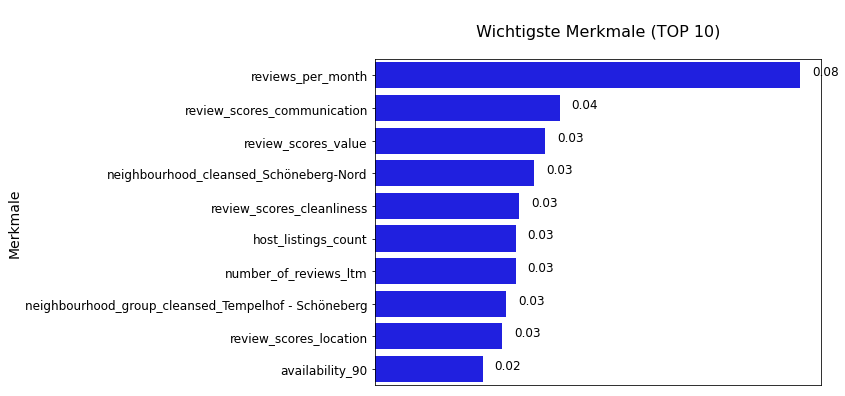

In [25]:
# Wichtige Merkmale plotten

plt.figure(figsize=(8,6));
sns.barplot(y = features, x = score, color = 'blue');
plt.xticks([])
plt.yticks(fontsize = 12)
plt.xlabel('')
plt.ylabel('Merkmale', fontsize = 14);
plt.title('\n Wichtigste Merkmale (TOP 10) \n', fontsize = 16);

locs, labels = plt.yticks()

for loc, label in zip(locs, labels):
    plt.text(score[loc]+.005, loc, '{:0.2f}'.format(score[loc]), ha = 'center', color = 'black', fontsize = 12)